<a href="https://colab.research.google.com/github/quangnhat1395/MLEF1/blob/master/MLEF1_Lecture_06_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Example

Reference: https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/

(a) Suppose we have a neural network in the above graph .
In this problem, we are going to use the notations from [4], where $\textbf{W}^{(l)}$ and $\textbf{b}^{(l)}$ are respectively the weight matrix and the bias vector between the $(l-1)^{th}$ layer and $l^{th}$ layer, $l=1,2,3$. Suppose further that we use the sigmoid function as the activation function. 
* Write the feedforward equations to calculate the output from the inputs 
* Write the backpropgation equations to calculate the gradient of the loss function $J(\mathbf{W, b, X, Y})$ with respect to $\textbf{W}^{(l)}$ and $\textbf{b}^{(l)}$ .

(b) Using the training set and test set from https://github.com/zalandoresearch/fashion-mnist, build a neural network with $784$ inputs and the biases, and $10$ outputs. You have to implement the Backpropagation algorithm and Gradient Descent algorithm by yourself. 

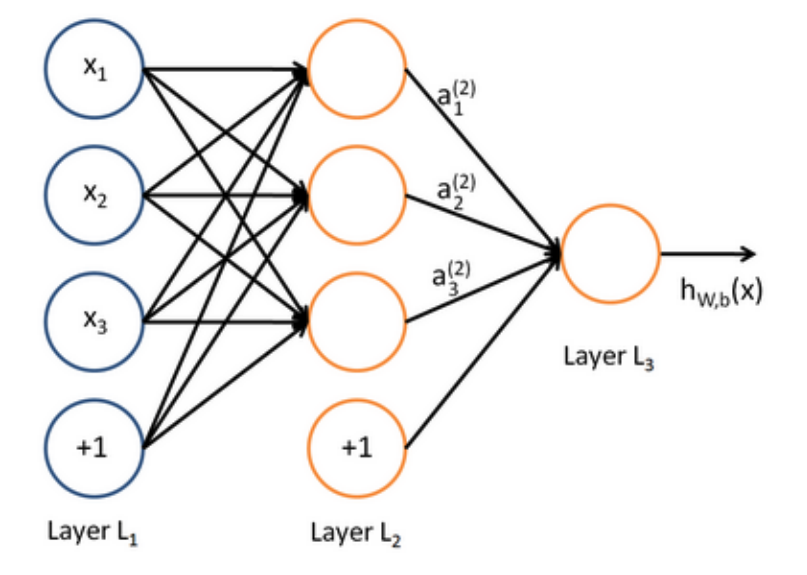

## Notes:


*   In this implementation, we use the cross entropy (of $y$ and $\hat{y}$) as the loss function. Other loss functions (such as MSE) are acceptable as long as the partial derivatives are correctly calculated
*   In this implementation, we use a softmax function at the output layer to calculate the probability vector of the prediction. It is OK to use separate sigmoid functions (as in the Lecture) to calculate the probabilities. Each probability will be interpreted as the probability that the output = i in a one-vs-rest classification. 




  


In [ ]:
import numpy as np
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
(Xtrain, y_train), (Xtest, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print("Xtrain[0, :, :]: \n", Xtrain[0, :, :])

Xtrain[0, :, :]: 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1

In [ ]:
print("Xtrain shape: " + str(Xtrain.shape))
print("y_train shape: " + str(y_train.shape))
print("Xtest shape: " + str(Xtest.shape))
print("y_test shape: " + str(y_test.shape))

Xtrain shape: (60000, 28, 28)
y_train shape: (60000,)
Xtest shape: (10000, 28, 28)
y_test shape: (10000,)


In [ ]:
# Normalize data
X_train = Xtrain / 255
X_test = Xtest / 255

# Flatten the input matrix
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [ ]:
# Convert the output to OneHotEncoding vector
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y_train.reshape(-1,1))
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [ ]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: ", len(X_train))
print ("Number of testing examples: ", len(X_test))

X_train shape: (60000, 784)
y_train shape: (60000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)
Number of training examples:  60000
Number of testing examples:  10000


In [ ]:
# Utils function
def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(Y_hat, Y):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[0]
    L = -(1/m) * L_sum
    return L

# Define the class for Neural net
class NeuralNetwork:
    def __init__(self, x, y, hidden_size = 100, learning_rate=0.5):
        self.x = x
        hd_dim = hidden_size # Number of neurons in hidden layer
        self.lr = learning_rate
        ip_dim = x.shape[1] # Number of input features
        op_dim = y.shape[1] # Number of output classes

        # Initializing the parameters
        self.w1 = np.random.randn(ip_dim, hd_dim)
        self.b1 = np.zeros((1, hd_dim))
        self.w2 = np.random.randn(hd_dim, op_dim)
        self.b2 = np.zeros((1, op_dim))
        self.y = y
        
        self.loss_history = []

    def feedforward(self):
        self.z1 = np.matmul(self.x, self.w1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.matmul(self.a1, self.w2) + self.b2
        self.a2 = softmax(self.z2)
        
    def backprop(self):
        # Compute the loss value
        loss_value = cross_entropy(self.a2, self.y)
        self.loss_history.append(loss_value)
        
        # Backpropagation
        m = self.x.shape[0]
        dZ2 = self.a2- self.y
        dW2 = (1./m) * np.matmul(self.a1.T, dZ2)
        db2 = (1./m) * np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.matmul(dZ2, self.w2.T)
        dZ1 = dA1 * sigmoid(self.z1) * (1 - sigmoid(self.z1))
        dW1 = (1./m) * np.matmul(self.x.T, dZ1)
        db1 = (1./m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update parameters
        self.w2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.w1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X_pred):
        temp = self.x
        self.x = X_pred
        self.feedforward()
        self.x = temp
        return self.a2
    
    def get_acc(self, X_test, y_test):
        y_pred = self.predict(X_test).argmax(1)
        y_test = y_test.argmax(1)
        acc = np.sum(y_pred == y_test)/len(y_pred)
        return acc

In [ ]:
model = NeuralNetwork(X_train, y_train, hidden_size=50, learning_rate=1)

epochs = 1000
train_acc_list = []
test_acc_list = []
for i in range(epochs):
    model.feedforward()
    model.backprop()
    train_acc = model.get_acc(X_train, y_train)
    train_acc_list.append(train_acc)
    test_acc = model.get_acc(X_test, y_test)
    test_acc_list.append(test_acc)
    if (i+1)%10 == 0:
        print('Epoch {} -- Loss: {:.4f} -- Training Accuracy: {:.4f} -- Test Accuracy: {:.4f}'.format(i+1, model.loss_history[-1], train_acc, test_acc))

Epoch 10 -- Loss: 1.9323 -- Training Accuracy: 0.4196 -- Test Accuracy: 0.4075
Epoch 20 -- Loss: 1.4005 -- Training Accuracy: 0.5348 -- Test Accuracy: 0.5217
Epoch 30 -- Loss: 1.2113 -- Training Accuracy: 0.5850 -- Test Accuracy: 0.5744
Epoch 40 -- Loss: 1.1050 -- Training Accuracy: 0.6187 -- Test Accuracy: 0.6130
Epoch 50 -- Loss: 1.0344 -- Training Accuracy: 0.6391 -- Test Accuracy: 0.6312
Epoch 60 -- Loss: 0.9832 -- Training Accuracy: 0.6527 -- Test Accuracy: 0.6438
Epoch 70 -- Loss: 0.9438 -- Training Accuracy: 0.6609 -- Test Accuracy: 0.6546
Epoch 80 -- Loss: 0.9118 -- Training Accuracy: 0.6697 -- Test Accuracy: 0.6630
Epoch 90 -- Loss: 0.8849 -- Training Accuracy: 0.6780 -- Test Accuracy: 0.6717
Epoch 100 -- Loss: 0.8618 -- Training Accuracy: 0.6851 -- Test Accuracy: 0.6792
Epoch 110 -- Loss: 0.8415 -- Training Accuracy: 0.6918 -- Test Accuracy: 0.6863
Epoch 120 -- Loss: 0.8235 -- Training Accuracy: 0.6980 -- Test Accuracy: 0.6913
Epoch 130 -- Loss: 0.8073 -- Training Accuracy: 0

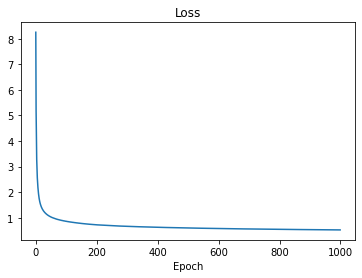

In [ ]:
plt.plot(model.loss_history,
         label='Training Loss'
        )
plt.xlabel('Epoch')
plt.title('Loss')
plt.show()

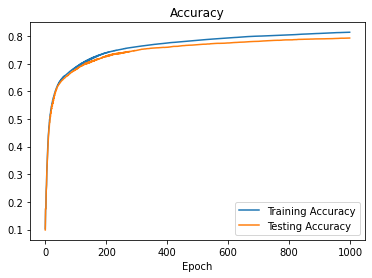

In [ ]:
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()